<img src="http://xarray.pydata.org/en/stable/_static/dataset-diagram-logo.png" align="center" width="30%">

## 02_Xarray: Plotting

## Overview
1. Work with an Xarray `Dataset`
2. Select a variable from the dataset
3. Create a contour plot of gridded CFSR reanalysis data

## Imports

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from metpy.units import units
import metpy.calc as mpcalc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

## Work with an Xarray `Dataset`

An Xarray [Dataset](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.html) consists of one or more `DataArray`s. Let's continue to work with the CFSR NetCDF files from the previous notebook. 

In [2]:
year = 2013
ds_slp = xr.open_dataset(f'/cfsr/data/{year}/pmsl.{year}.0p5.anl.nc')
ds_g = xr.open_dataset(f'/cfsr/data/{year}/g.{year}.0p5.anl.nc')

Examine the SLP dataset

In [3]:
ds_slp

<xarray.Dataset>
Dimensions:  (time: 1460, lat: 361, lon: 720)
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2013-12-31T18:00:00
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
Data variables:
    pmsl     (time, lat, lon) float32 ...
Attributes:
    description:    pmsl as a single level variable
    year:           2013
    source:         http://nomads.ncdc.noaa.gov/data.php?name=access#CFSR-data
    references:     Saha, et. al., (2010)
    created_by:     User: abrammer
    creation_date:  Sat Nov  9 12:03:30 MST 2013

One attribute of a dataset is its size. We can access that via its `nbytes` attribute.

In [4]:
print (f'Size of dataset: {ds_slp.nbytes / 1e6} MB')

Size of dataset: 1517.948804 MB


Select a variable from the dataset and assign it to a `DataArray` object

In [5]:
slp = ds_slp['pmsl'] # Similar to selecting a Series in Pandas

In [6]:
slp

<xarray.DataArray 'pmsl' (time: 1460, lat: 361, lon: 720)>
[379483200 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2013-12-31T18:00:00
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
Attributes:
    level_type:  single level variable
    units:       Pa
    long_name:   pressure reduced mean sea level

We see that `slp` is a 3-dimensional DataArray, with time ('time') as the first dimension.

## Create a contour plot of gridded data

We got a quick plot in the previous notebook. Let's now customize the map, and focus on a particular region. We will use Cartopy and Matplotlib to plot our SLP contours. Matplotlib has two contour methods:
1. [Line contours: ax.contour](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.contour.html)
2. [Filled contours: ax.contourf](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.contourf.html)

We will draw contour lines in hPa, with a contour interval of 4.

#### As we've done before, let's first define some variables relevant to Cartopy.

The CFSR data's x- and y- coordinates are longitude and latitude ... thus, its projection is Plate Carree. However, we wish to display the data on a regional map that uses Lambert Conformal. So we will define two Cartopy projection objects here. We will need to *transform* the data from its native projection to the map's projection when it comes time to draw the contours.

In [55]:
#cLon = -97.5
#cLat = 35
cLon= (lonW + lonE) / 2
cLat = (latS + latN) / 2
lonW = -110
lonE = -85
latS = 30
latN = 50
proj_data = ccrs.PlateCarree() # Our data is lat-lon; thus its native projection is Plate Carree.
proj_map = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat) # Map projection
res = '50m'
cLon

-100.0

#### Now define the range of our contour values and a contour interval. 4 hPa is standard for a sea-level pressure map on a synoptic-scale region.

In [56]:
minVal = 900
maxVal = 1076
cint = 4
cintervals = np.arange(minVal, maxVal, cint)
cintervals

array([ 900,  904,  908,  912,  916,  920,  924,  928,  932,  936,  940,
        944,  948,  952,  956,  960,  964,  968,  972,  976,  980,  984,
        988,  992,  996, 1000, 1004, 1008, 1012, 1016, 1020, 1024, 1028,
       1032, 1036, 1040, 1044, 1048, 1052, 1056, 1060, 1064, 1068, 1072])

#### Matplotlib's contour methods require *three arrays* to be passed to them ... x- and y- arrays (longitude and latitude in our case), and a 2-d array (corresponding to x- and y-) of our data variable. So we need to extract the latitude and longitude coordinate variables from our DataArray. We'll also extract the third coordinate value, time.

In [57]:
lats = ds_slp.lat
lons = ds_slp.lon
times = ds_slp.time

Let's use Xarray's `sel` method to specify one time from the `DataArray`.

In [58]:
slp_singleTime = slp.sel(time='2013-05-20-18:00:00')

In [59]:
slp_singleTime

<xarray.DataArray 'pmsl' (lat: 361, lon: 720)>
[259920 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 2013-05-20T18:00:00
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
Attributes:
    level_type:  single level variable
    units:       Pa
    long_name:   pressure reduced mean sea level

Note the units are in Pascals. We will exploit MetPy's unit conversion library soon, but for now let's just divide the array by 100.

In [60]:
slp_singleTimeHPA = slp_singleTime / 100

#### We're set to make our map. After creating our figure, setting the bounds of our map domain, and adding cartographic features, we will plot the contours. We'll assign the output of the contour method to an object, which will then be used to label the contour lines.

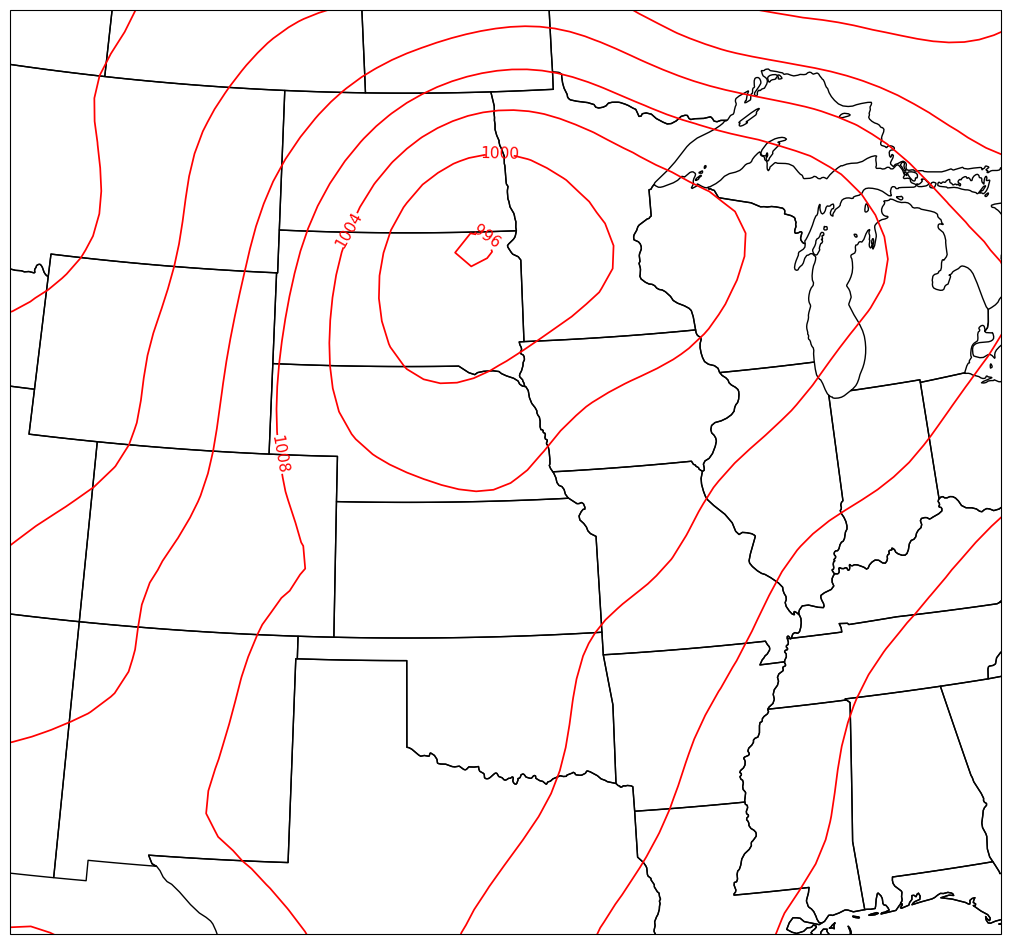

In [61]:
fig = plt.figure(figsize=(18,12))
ax = plt.subplot(1,1,1,projection=proj_map)
ax.set_extent ([lonW,lonE,latS,latN])
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.STATES.with_scale(res))
CL = ax.contour(lons,lats,slp_singleTimeHPA,cintervals,transform=proj_data,linewidths=1.25,colors='red')
ax.clabel(CL, inline_spacing=0.2, fontsize=11, fmt='%.0f');

### There we have it! There are definitely some things we can improve about this plot (such as the lack of an informative title, and the fact that our contour labels seem not to be appearing on every contour line), but we'll get to that in the next lesson!